# Generador de imágenes - cVAE

Importamos las librerías necesarias para el proyecto.

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
from typing import Optional, Callable
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader
import urllib.request
from zipfile import ZipFile
import torch.optim as optim
from torchvision import transforms, utils as vutils


Este bloque importa las librerías necesarias para el proyecto.

In [ ]:
DATASET_ZIP_URL = "https://www.dropbox.com/scl/fi/buygp1u3dlvql1omlgii6/title30cat.zip?rlkey=emlr8c439whnexhezqjanlr19&st=58w2deja&dl=1"
CSV_TEST_URL = "https://www.dropbox.com/scl/fi/5qgqwksr9rz510cqqyzip/book30-listing-test.csv?rlkey=xu6m7bfbp9noefc91difpzix7&st=pmbqqis8&dl=1"
CSV_TRAIN_URL = "https://www.dropbox.com/scl/fi/b28fi1cd6k4vtaj0en1lu/book30-listing-train.csv?rlkey=dd4lrdkoleiedezjzx9ing1yb&st=jwcx2hys&dl=1"

# en caso de no tener los archivos CSV descomente las líneas superiores

DATASET_PATH = "./224x224"
CSV_TEST_PATH = "./book30-listing-test.csv"
CSV_TRAIN_PATH = "./book30-listing-train.csv"
ZIP_PATH = "./title30cat.zip"

if not os.path.exists(DATASET_PATH):
    urllib.request.urlretrieve(DATASET_ZIP_URL, ZIP_PATH)
    with ZipFile(ZIP_PATH, "r") as zip_ref:
        zip_ref.extractall(".")
    os.remove(ZIP_PATH)
    print("Dataset descargado y descomprimido exitosamente.")
else:
    print("El dataset ya está descargado.")

if not os.path.exists(CSV_TEST_PATH):
    urllib.request.urlretrieve(CSV_TEST_URL, CSV_TEST_PATH)
    print("CSV de prueba descargado exitosamente.")
else:
    print("El CSV de prueba ya está descargado.")

if not os.path.exists(CSV_TRAIN_PATH):
    urllib.request.urlretrieve(CSV_TRAIN_URL, CSV_TRAIN_PATH)
    print("CSV de entrenamiento descargado exitosamente.")
else:
    print("El CSV de entrenamiento ya está descargado.")

Dataset descargado y descomprimido exitosamente.
CSV de prueba descargado exitosamente.
CSV de entrenamiento descargado exitosamente.


Esta celda define la clase LibrosDataset, que es un Dataset personalizado para cargar las imágenes de portadas y sus etiquetas de género desde un archivo CSV. Incluye transformaciones básicas para las

In [ ]:
class LibrosDataset(Dataset):
    def __init__(self, csv_path: str, images_dir: str):
        """
        Dataset para imágenes de portadas con etiquetas desde un CSV.

        Args:
            csv_path (str): Ruta al archivo CSV con columnas 'filename' y 'genre'.
            images_dir (str): Carpeta donde están las imágenes.
        """
        self.data = pd.read_csv(csv_path, delimiter=";")
        self.images_dir = images_dir
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)), # 224??
            transforms.ToTensor(),
            # transforms.Normalize([0.5]*3, [0.5]*3)
            ])

        # Crear un mapeo de género a índice y viceversa
        self.genres = sorted(self.data['Category'].unique())
        self.genre_to_idx = {genre: idx for idx, genre in enumerate(self.genres)}
        self.idx_to_genre = {idx: genre for genre, idx in self.genre_to_idx.items()}

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.images_dir, row['Filename'])
        label_idx = self.genre_to_idx[row['Category']]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label_tensor

Este bloque define la arquitectura del Conditional Variational Autoencoder (CVAE), incluyendo el codificador, el decodificador y la función de reparametrización.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, z_dim=64, num_classes=10):
        super(CVAE, self).__init__()
        self.num_classes = num_classes

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3 + num_classes, 32, 4, 2, 1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),               # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),              # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1),             # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, z_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, z_dim)

        # Decoder
        self.fc_decode = nn.Linear(z_dim + num_classes, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),     # 32x32 -> 64x64
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        one_hot = F.one_hot(labels, num_classes=self.num_classes).float()
        one_hot_expanded = one_hot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
        x_cond = torch.cat([x, one_hot_expanded], dim=1)

        h = self.encoder(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)

        z_cond = torch.cat([z, one_hot], dim=1)
        h_dec = self.fc_decode(z_cond)
        x_recon = self.decoder(h_dec)
        return x_recon, mu, logvar


In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return 3 * recon_loss + kl_div


Este bloque monta Google Drive para permitir el guardado automático de checkpoints durante el entrenamiento. En caso de no poder acceder, se puede ejecutar la celda de debajo

In [ ]:
# Para poder autoguardar en el drive

from google.colab import drive
drive.mount('/content/drive')

DRIVE_CHECKPOINT_DIR = '/content/drive/MyDrive/'

Mounted at /content/drive


In [ ]:
# alternativamente

os.mkdir('/content/drive')

DRIVE_CHECKPOINT_DIR = '/content/drive'

Esta celda define la función train para entrenar el modelo CVAE. Incluye el bucle de entrenamiento, cálculo de pérdida, optimización, y guardado de checkpoints periódicamente.

In [ ]:
def train(model, dataloader, optimizer, device, epochs=20, start_epoch=0, losses_history=None):
    model.train()
    # Inicializar el animador para graficar la pérdida
    # Si se proporciona historial de pérdidas, usarlo para inicializar el gráfico
    if losses_history is None:
        losses_history = []
        initial_epochs = []
    else:
        initial_epochs = list(range(1, start_epoch + 1)) # Épocas correspondientes al historial cargado

    animator = Animator(xlabel='epoch', ylabel='loss', xlim=[1, epochs], legend=['train loss'])

    # Añadir los datos históricos al animador si existen
    if initial_epochs:
        animator.add(initial_epochs, losses_history)


    for epoch in range(start_epoch, epochs):
        total_loss = 0
        for x, labels in dataloader:
            x, labels = x.to(device), labels.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x, labels)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        losses_history.append(avg_loss) # Almacenar la pérdida promedio de la época actual
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        # Agregar el punto de pérdida actual al animador
        animator.add(epoch + 1, avg_loss)


        # Guardar checkpoint cada 5 épocas
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(DRIVE_CHECKPOINT_DIR, f'cvae_checkpoint.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss, # Guardar la pérdida promedio de la época
                'losses_history': losses_history # Guardar el historial de pérdidas acumulado
            }, checkpoint_path)
            print(f"Checkpoint guardado en época {epoch+1}")
            # Guardar el gráfico al finalizar el entrenamiento
            plot_save_path = os.path.join(DRIVE_CHECKPOINT_DIR, 'training_loss_plot.png')
            animator.fig.savefig(plot_save_path)
            print(f"Gráfico de pérdida guardado en: {plot_save_path}")

Este bloque inicializa el dispositivo (GPU si está disponible, de lo contrario CPU), carga el dataset de entrenamiento, crea un DataLoader y inicializa el modelo CVAE y el optimizador.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataset = LibrosDataset(CSV_TRAIN_PATH, DATASET_PATH)
dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
model = CVAE(z_dim=64, num_classes=len(train_dataset.genres)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Este bloque carga un checkpoint previamente guardado para continuar el entrenamiento desde donde se dejó. Necesario debido a las limitaciones que da Colab.

In [ ]:
# para cargar
checkpoint = torch.load('drive/MyDrive/cvae_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
average_loss = checkpoint['loss']
start_epoch = checkpoint['epoch'] + 1
print(f"✔️ Checkpoint cargado. Continuando desde la época {start_epoch}")

✔️ Checkpoint cargado. Continuando desde la época 55


Definimos el espacio latente aprendido por la CVAE en 2D.

In [ ]:
def plot_latent(autoencoder, data, num_batches=100, rectangle = None):
    autoencoder.eval()

    all_z = []
    all_labels = []

    with torch.no_grad(): # Deshabilita el cálculo de gradientes
        for i, (x, y) in enumerate(data):
            # Mueve los datos al dispositivo correcto (CPU o GPU)
            x = x.to(device)
            y = y.to(device) # También necesitamos las etiquetas en el dispositivo

            # Codifica la imagen *condicionada por la etiqueta*
            # La entrada al encoder de tu CVAE es la imagen concatenada con la etiqueta one-hot
            one_hot = F.one_hot(y, num_classes=autoencoder.num_classes).float()
            one_hot_expanded = one_hot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.size(2), x.size(3))
            x_cond = torch.cat([x, one_hot_expanded], dim=1)

            # Pasa la entrada condicionada por el encoder
            h = autoencoder.encoder(x_cond)
            # Obtén la media (mu) del espacio latente. Esta es la representación que queremos visualizar.
            mu = autoencoder.fc_mu(h)

            # Mueve los resultados a la CPU y conviértelos a numpy
            mu_cpu = mu.to('cpu').detach().numpy()
            labels_cpu = y.to('cpu').detach().numpy()

            # Almacena los resultados
            all_z.append(mu_cpu)
            all_labels.append(labels_cpu)

            # Rompe el bucle si se alcanza el número de lotes
            if i >= num_batches - 1: # Usar >= num_batches - 1 porque i empieza en 0
                break

    # Concatena los resultados de todos los lotes
    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Realiza el plot utilizando todos los puntos recopilados
    plt.figure(figsize=(10, 8)) # Opcional: ajusta el tamaño de la figura
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', s=10) # s ajusta el tamaño de los puntos
    plt.title('Latent Space Visualization') # Opcional: añade un título
    plt.xlabel('Latent Dimension 1') # Opcional: añade etiquetas a los ejes
    plt.ylabel('Latent Dimension 2') # Opcional: añade etiquetas a los ejes

    # Añade la barra de color con las etiquetas correctas
    # Necesitamos mapear los índices de vuelta a los nombres de género para la barra de color
    # Asumiendo que tienes acceso a train_dataset.idx_to_genre
    if hasattr(data.dataset, 'idx_to_genre'):
        cbar = plt.colorbar(scatter, ticks=list(data.dataset.idx_to_genre.keys()))
        cbar.set_ticklabels([data.dataset.idx_to_genre[i] for i in sorted(data.dataset.idx_to_genre.keys())])
        cbar.set_label('Genre')
    else:
         plt.colorbar(scatter) # Si no hay mapeo, solo muestra los índices numéricos

    # Dibuja el rectángulo si está especificado
    if rectangle is not None:
        rect = plt.Rectangle((rectangle[0], rectangle[1]), rectangle[2], rectangle[3], facecolor='none', ec="red", lw=2) # lw ajusta el grosor de la línea
        plt.gca().add_patch(rect)

    plt.grid(True, linestyle='--', alpha=0.6) # Opcional: añade una cuadrícula
    plt.show()

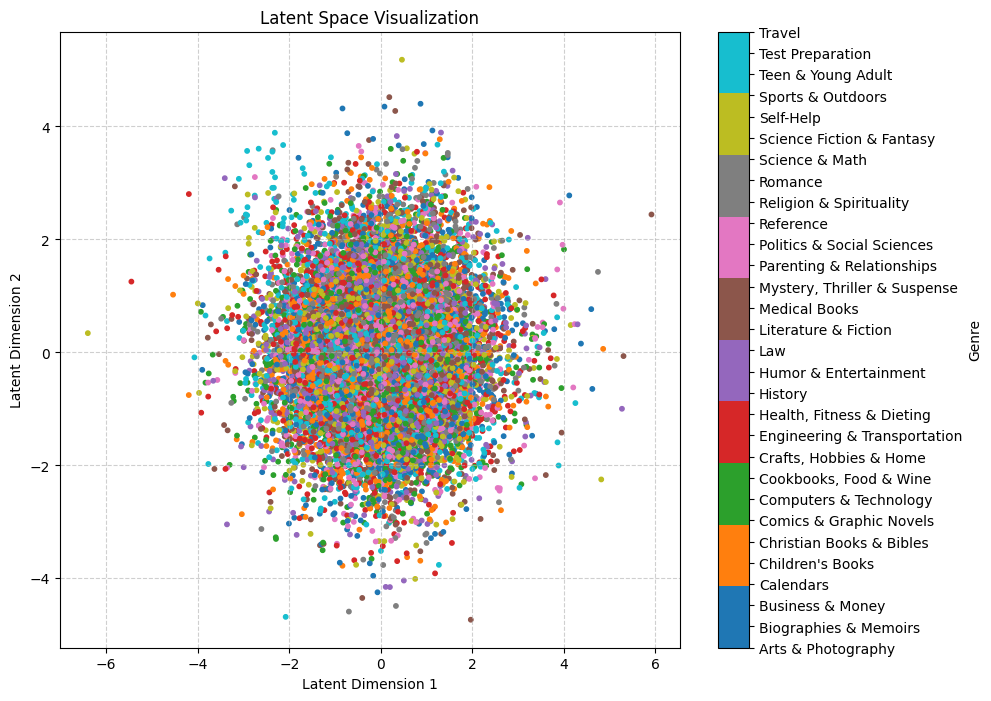

In [ ]:
plot_latent(model, dataloader)

Ejecutmos el entrenamiento

In [ ]:
train(model, dataloader, optimizer, device, epochs=900, start_epoch=start_epoch)

Código construido para la generación por género de las imágenes.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F
import random

def generar_por_genero_cvae(model, z_dim, genre_id, num_classes, device, idx_to_genre, dataloader, num_imgs=8):
    model.eval()
    with torch.no_grad():
        latent_vectors = []
        # Recopilar vectores latentes de imágenes reales del género deseado
        for x, labels in dataloader:
            x = x.to(device)
            labels = labels.to(device)

            # Filtrar por el género deseado
            genre_indices = (labels == genre_id).nonzero(as_tuple=True)[0]
            if genre_indices.numel() > 0:
                x_genre = x[genre_indices]
                labels_genre = labels[genre_indices]

                # Pasar por el encoder
                one_hot = F.one_hot(labels_genre, num_classes=num_classes).float()
                one_hot_expanded = one_hot.unsqueeze(2).unsqueeze(3).expand(-1, -1, x_genre.size(2), x_genre.size(3))
                x_cond = torch.cat([x_genre, one_hot_expanded], dim=1)

                h = model.encoder(x_cond)
                mu = model.fc_mu(h)
                # Puedes usar 'mu' directamente para un resultado más predecible
                # o usar la reparametrización para más variabilidad:
                # logvar = model.fc_logvar(h)
                # z = model.reparameterize(mu, logvar)
                z = mu # Usamos la media para un resultado más representativo del género

                latent_vectors.append(z.cpu())

                # Si ya tenemos suficientes vectores latentes, salimos
                if torch.cat(latent_vectors).size(0) >= num_imgs:
                    break

        if not latent_vectors:
            print(f"No se encontraron imágenes para el género {idx_to_genre[genre_id]} en el dataloader.")
            return

        # Concatenar los vectores latentes recopilados y seleccionar num_imgs
        all_latent_vectors = torch.cat(latent_vectors)[:num_imgs].to(device)

        # One-hot del género para el decoder
        labels_for_decoder = torch.full((num_imgs,), genre_id, dtype=torch.long).to(device)
        one_hot_for_decoder = F.one_hot(labels_for_decoder, num_classes=num_classes).float()

        # Concatenar los vectores latentes derivados de datos + one-hot y pasar por el decoder
        z_cond = torch.cat([all_latent_vectors, one_hot_for_decoder], dim=1)
        h_dec = model.fc_decode(z_cond)
        fake_imgs = model.decoder(h_dec).detach().cpu()

        # Mostrar imágenes
        grid = vutils.make_grid(fake_imgs, nrow=4, normalize=True)
        plt.figure(figsize=(8, 4))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.title(f"Género: {idx_to_genre[genre_id]} (Generado desde datos reales)")
        plt.show()


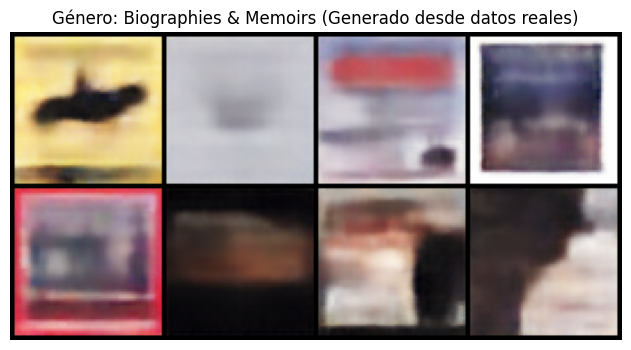

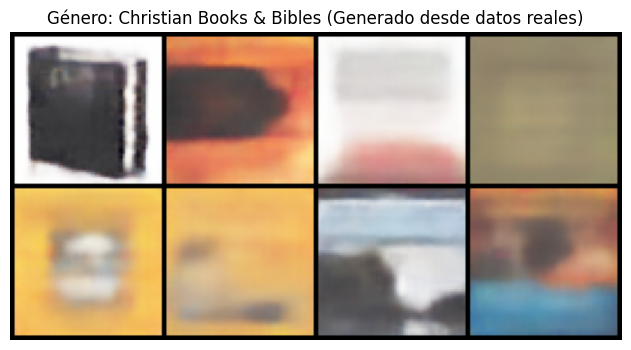

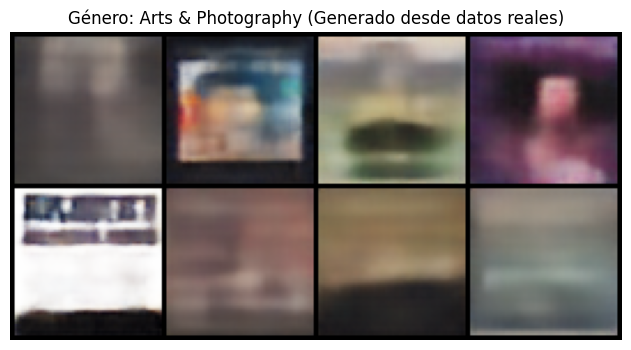

In [ ]:
generar_por_genero_cvae(
    model=model,
    z_dim=64,
    genre_id=1,  # por ejemplo, "Fantasía"
    num_classes=len(train_dataset.genres),
    device=device,
    idx_to_genre=train_dataset.idx_to_genre,
    dataloader=dataloader,
    num_imgs=8
)

generar_por_genero_cvae(
    model=model,
    z_dim=64,
    genre_id=5,  # por ejemplo, "Fantasía"
    num_classes=len(train_dataset.genres),
    device=device,
    idx_to_genre=train_dataset.idx_to_genre,
    dataloader=dataloader,
    num_imgs=8
)

generar_por_genero_cvae(
    model=model,
    z_dim=64,
    genre_id=0,  # por ejemplo, "Fantasía"
    num_classes=len(train_dataset.genres),
    device=device,
    idx_to_genre=train_dataset.idx_to_genre,
    dataloader=dataloader,
    num_imgs=8
)


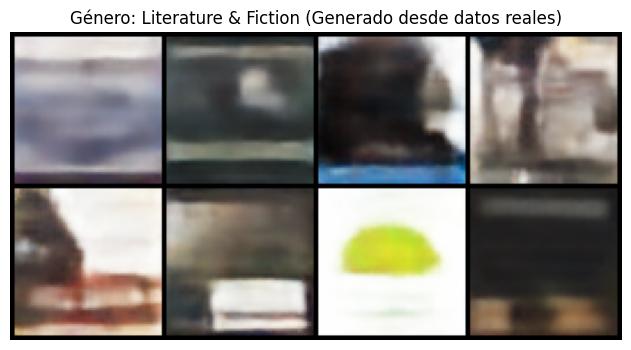

In [ ]:
generar_por_genero_cvae(
    model=model,
    z_dim=64,
    genre_id=15,  # por ejemplo, "Fantasía"
    num_classes=len(train_dataset.genres),
    device=device,
    idx_to_genre=train_dataset.idx_to_genre,
    dataloader=dataloader,
    num_imgs=8
)

Celda ejecutada previamente con 50 Epochs

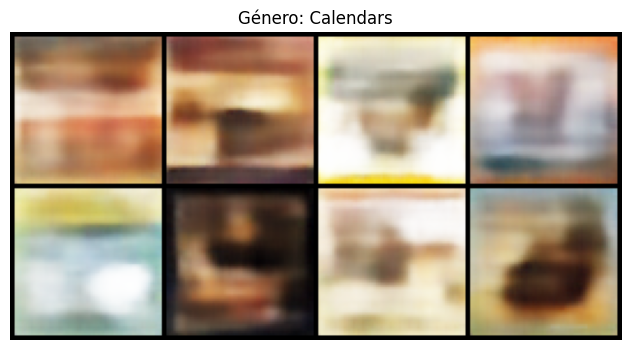

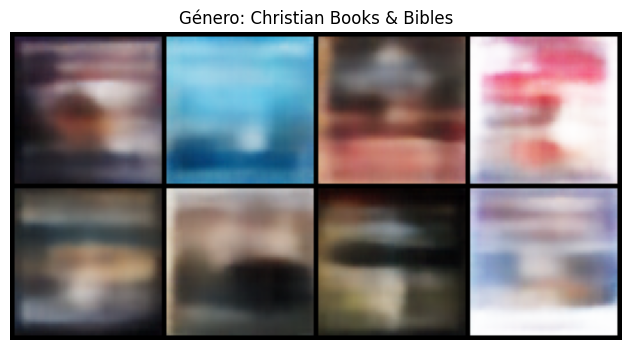

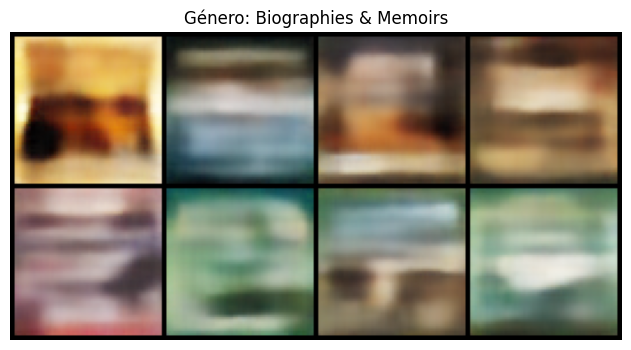

In [ ]:
# Generado con 50 epochs